### 1、导入package

<img src = '1.png',width=400,height=400>

In [1]:
import pandas as pd
pd.options.display.max_columns = None
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from scipy import stats
from sklearn.metrics import roc_curve, accuracy_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier as kNearestNeighbors

可以考虑划分训练集为0.8训练集，0.2测试集，0.8训练集交叉验证，0.2测试集看效果  
http://sofasofa.io/forum_main_post.php?postid=1000545

对于含有0的托福雅思成绩，  
或者你也可以用众数、中位数、均值取填充这些含有0的数据，  
你可以试一下每种方法测一下交叉验证的准确率，找个效果最好的策略

连续值特征进行离散化处理，那些重要的成绩可以分档次做成类别型onehot

什么都不做，完全稠密性特征，用Xgboost试一下效果

No,第一个特征有没有可能是有用的，分析一下

试一下DNN

train.loc[(train[' GPA']>4.0) & (train['rank']==0)]

先做rank二分类、判断是0还是非0，然后再对非0做三分类

判断通用模型对于每个类的预测准确率，看对哪个类预测最不准

把雅思为0和非0的分开建模

### 2、读取数据

In [2]:
train = pd.read_csv('EdTech_train_data.csv')
test  = pd.read_csv('EdTech_test_data.csv')

### 3、数据分析

#### 3.1查看label是否均衡

In [3]:
train.describe()
#可以看出year有异常数据

,No,Education,Major,Year,Target Major,Degree Application,GPA,GMAT,IBT,GRE,IETLS,Distinguished Internship,General Internship,Research Experience,Other Experience,rank
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,497.960000,2.466667,181.933333,1975.480000,234.168889,1.228889,3.386561,185.234333,77.529667,161.180556,4.096667,1.836667,1.347778,1.961111,0.811111,1.565556
std,288.793826,0.797661,107.089060,257.334494,134.873658,0.526124,0.607469,308.326028,42.813497,153.742008,3.202750,1.586578,1.324092,2.215237,1.846709,0.987763
min,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,246.750000,2.000000,87.000000,2007.000000,101.750000,1.000000,3.290000,0.000000,81.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,501.500000,3.000000,190.000000,2009.000000,245.500000,1.000000,3.493000,0.000000,100.000000,248.404732,6.000000,2.000000,1.000000,1.000000,0.000000,2.000000
75%,743.250000,3.000000,280.250000,2010.000000,366.250000,1.000000,3.680000,610.000000,105.000000,318.000000,7.000000,3.000000,2.000000,3.000000,1.000000,2.000000
max,1000.000000,3.000000,352.000000,2016.000000,445.000000,3.000000,4.750000,781.500000,116.000000,338.000000,8.000000,7.000000,11.000000,11.000000,19.000000,3.000000


2    333
1    239
3    168
0    160
Name: rank, dtype: int64


Text(0.5,1,'rank class distribution')

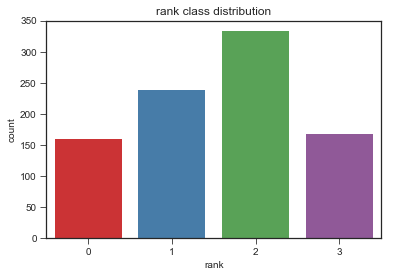

In [4]:
label = train['rank']
print(label.value_counts())
sns.set_style('ticks')       # 显示刻度，并取消网格
sns.set_palette('Set1')      # 配色使用Set1
ax = plt.axes() 
sns.countplot(x='rank',
              data=train,
              ax=ax) 
ax.set_title('rank class distribution')
#可以看到，类别基本均衡，不需要额外处理（比如采样或者smote之类的）

Text(0.5,1,'rank distribution')

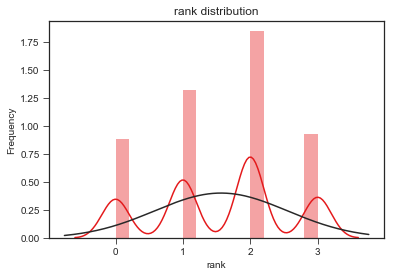

In [5]:
## 画出label的密度直方图
sns.distplot(train['rank'] , fit=norm)
plt.ylabel('Frequency')
plt.title('rank distribution')
#label总体服从正态分布

#### 3.2检查缺失值

In [6]:
na_count = train.isnull().sum().sort_values(ascending=False)
na_rate = na_count / len(train)
na_data = pd.concat([na_count,na_rate],axis=1,keys=['count','ratio'])
na_data.head(30)
#数据没有任何缺失

,count,ratio
rank,0,0.0
Other Experience,0,0.0
Research Experience,0,0.0
General Internship,0,0.0
Distinguished Internship,0,0.0
IETLS,0,0.0
GRE,0,0.0
IBT,0,0.0
GMAT,0,0.0
GPA,0,0.0


#### 3.3查看每个特征对应多少个值

In [7]:
train.head()

,No,Education,Major,Year,Target Major,Degree Application,GPA,GMAT,IBT,GRE,IETLS,Distinguished Internship,General Internship,Research Experience,Other Experience,rank
0,187,3,237,2010,171,1,3.70,0.0,102.0,327.500000,7.0,4,2,6,0,3
1,271,3,159,2009,349,1,3.38,0.0,97.0,272.211083,5.5,2,2,5,0,2
2,790,3,273,2011,293,3,3.40,0.0,101.0,325.000000,7.0,4,2,6,5,3
3,579,3,299,2008,372,1,3.80,0.0,0.0,0.000000,0.0,1,0,1,0,0
4,479,3,224,2009,275,2,3.27,0.0,88.0,320.000000,6.0,2,0,5,0,2


In [8]:
nunique = train.nunique() 
print(nunique.sort_values())

Degree Application            3
Education                     4
rank                          4
IETLS                         8
Distinguished Internship      8
General Internship            9
Research Experience          10
Other Experience             13
Year                         14
IBT                          45
GMAT                         50
 GPA                        150
GRE                         170
Major                       332
Target Major                419
No                          900
dtype: int64


#### 3.4根据  1）每个特征不同值的个数  2）特征的实际意义  将特征分为类别型和数值型

类别型特征：  
1)Degree Application：特征不同值个数只有三个，而且1 2 3之间没有实际的大小关系  
2)Education：0123之间学校由差到好，可以分为类别型也可以数值型，可以都尝试一下看看效果  
3)IETLS：类似Education，可以分为类别型也可以数值型，可以都尝试一下看看效果   
4)Distinguished Internship：类似Education，可以分为类别型也可以数值型，可以都尝试一下看看效果  
5)General Internship：类似Education，可以分为类别型也可以数值型，可以都尝试一下看看效果  
6)Research Experience：类似Education，可以分为类别型也可以数值型，可以都尝试一下看看效果  
7)Other Experience:类似Education，可以分为类别型也可以数值型，可以都尝试一下看看效果  
8)year:类似Education，可以分为类别型也可以数值型，可以都尝试一下看看效果

数值型特征：  
1)IBT:托福分数，可比较    
2)GMAT:可比较    
3)GPA  
4)GRE  
5)Major:做onehot维度爆炸，单独分析  
6)Target Major：做onehot维度爆炸，单独分析

特征idea1：如对于Gmat，IETLS,IBT，GRE那几列，很多人分数为0，所以可以新增一列判断是否为0  
特征idea2：对于major和taget major分析一下它们各自钰rank的相关性，直接onehot会维度爆炸  
特征idea3：注意GPA为0的异常值  
特征idea4：经验判断，比如有GRE和Gmat的人更会申请博士还是硕士

#### 3.5数值型特征分析

1、IBT

In [9]:
train.IBT.value_counts()

0.0      204
103.0     57
101.0     50
100.0     44
102.0     40
105.0     40
104.0     34
110.0     33
107.0     30
109.0     30
99.0      28
108.0     28
98.0      26
97.0      26
106.0     24
91.0      18
111.0     17
90.0      17
95.0      15
96.0      14
94.0      13
93.0      12
88.0      10
80.0      10
113.0      9
92.0       9
86.0       9
85.0       7
112.0      6
82.0       5
84.0       5
89.0       5
114.0      5
87.0       4
116.0      3
70.0       2
60.0       2
76.0       2
7.0        1
79.0       1
83.0       1
115.0      1
81.0       1
61.0       1
12.7       1
Name: IBT, dtype: int64

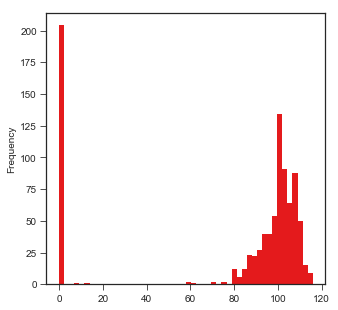

In [10]:
#查看对于类别的不同值个数
train.IBT.plot(kind = 'hist',bins = 50,figsize = (5,5))
plt.show()

Text(0.5,1,'IBT distribution')

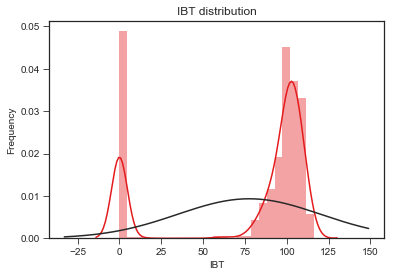

In [11]:
sns.distplot(train['IBT'],fit=norm)
plt.ylabel('Frequency')
plt.title('IBT distribution')
#很有必要对IBT单独新建一个特征，判断是否为0
#非0的其他分数基本服从正态分布

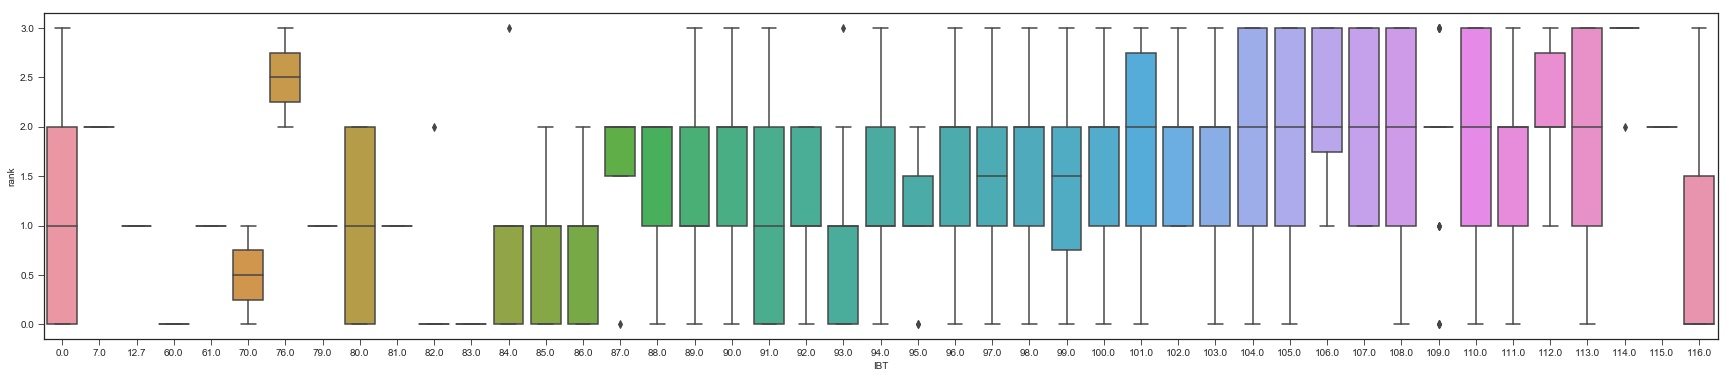

In [12]:
#由于label是类别型的，所以画箱线图
var = 'IBT'
data = pd.concat([train['rank'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(30, 6))
fig = sns.boxplot(x=var, y="rank", data=data)

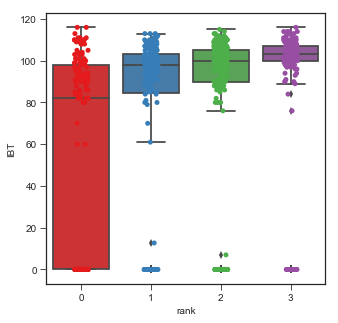

In [13]:
f,axarr = plt.subplots(1,1,figsize=(5,5))
sns.set_context("notebook", font_scale=1.8) # 放大横纵坐标标记，更容易看清
sns.stripplot(x='rank',y='IBT',data=train,jitter=True)
sns.boxplot(x='rank',y='IBT',data=train)
#可以看到，当申请到好学校时，学生的IBT成绩变化很大（噪声点比较多），但中位数可以明显看出成正相关

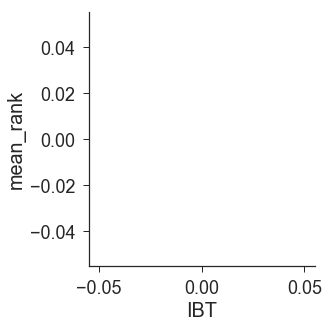

In [17]:
#根据IBT的分数来对rank做分组，求每个分组的均值
IBT_group_mean = pd.DataFrame()
IBT_group_mean['IBT'] = train.groupby("IBT").rank
IBT_group_mean['mean_rank'] = train.groupby("IBT").rank
# IBT_group_mean.plot(kind='scatter', x='IBT', y='mean_rank',alpha = 0.5,color = 'red')
# plt.xlabel('IBT')            
# plt.ylabel('mean_rank')
# plt.title('IBT mean_rank Scatter Plot')   
sns.lmplot(x="IBT" , y = "mean_rank" ,data = IBT_group_mean)
#总体上看还是成正相关的,虽然相关性不明显

2.GMAT

In [18]:
train.GMAT.value_counts()

0.00      657
710.00     34
720.00     19
700.00     19
690.00     18
680.00     14
760.00     14
660.00     13
730.00     13
750.00     10
640.00      9
740.00      9
610.00      5
650.00      5
620.00      5
770.00      4
670.00      4
714.50      3
600.00      3
734.50      3
630.00      3
590.00      2
744.50      2
580.00      2
694.50      2
704.50      2
755.00      2
550.00      2
674.00      1
634.00      1
725.50      1
735.00      1
560.00      1
704.00      1
664.00      1
644.50      1
11.19       1
715.00      1
12.10       1
714.00      1
241.80      1
325.50      1
719.50      1
765.50      1
415.31      1
723.00      1
756.00      1
781.50      1
310.00      1
755.50      1
Name: GMAT, dtype: int64

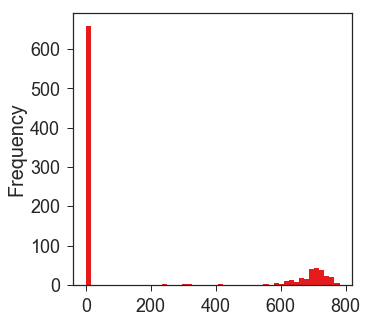

In [19]:
#查看对于类别的不同值个数
train.GMAT.plot(kind = 'hist',bins = 50,figsize = (5,5))
plt.show()

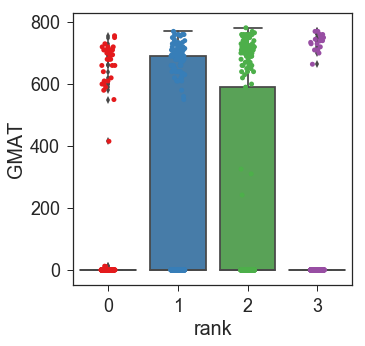

In [20]:
f,axarr = plt.subplots(1,1,figsize=(5,5))
sns.set_context("notebook", font_scale=1.8) 
sns.stripplot(x='rank',y='GMAT',data=train,jitter=True)
sns.boxplot(x='rank',y='GMAT',data=train)

In [21]:
#根据GMAT的分数来对rank做分组，求每个分组的均值
GMAT_group_mean = pd.DataFrame()
GMAT_group_mean['GMAT'] = train.groupby("GMAT").rank.mean().index
GMAT_group_mean['mean_rank'] = train.groupby("GMAT").rank.mean().values 
sns.lmplot(x="GMAT" , y = "mean_rank" ,data = GMAT_group_mean)
#总体上看还是成正相关的,虽然相关性不明显

AttributeError: 'function' object has no attribute 'mean'

3.GPA

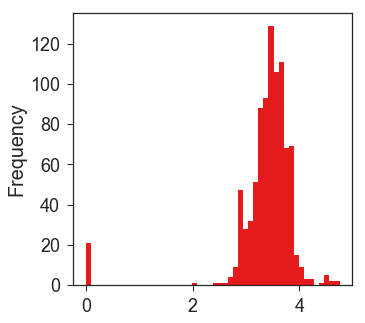

In [22]:
train[' GPA'].plot(kind = 'hist',bins = 50,figsize = (5,5))
plt.show()

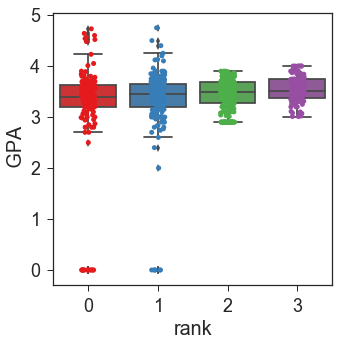

In [23]:
f,axarr = plt.subplots(1,1,figsize=(5,5))
sns.set_context("notebook", font_scale=1.8) 
sns.stripplot(x='rank',y=' GPA',data=train,jitter=True)
sns.boxplot(x='rank',y=' GPA',data=train)

In [24]:
#根据GPA的分数来对rank做分组，求每个分组的均值
GPA_group_mean = pd.DataFrame()
GPA_group_mean['GPA'] = train.groupby(" GPA").rank.mean().index
GPA_group_mean['mean_rank'] = train.groupby(" GPA").rank.mean().values 
sns.lmplot(x="GPA" , y = "mean_rank" ,data = GPA_group_mean)
#特别弱的正相关

AttributeError: 'function' object has no attribute 'mean'

4.GRE

In [ ]:
train['GRE'].plot(kind = 'hist',bins = 50,figsize = (5,5))
plt.show()

In [ ]:
f,axarr = plt.subplots(1,1,figsize=(5,5))
sns.set_context("notebook", font_scale=1.8) 
sns.stripplot(x='rank',y='GRE',data=train,jitter=True)
sns.boxplot(x='rank',y='GRE',data=train)
#结论：对于申到好学校来说，GRE普遍比较高

In [ ]:
#根据GRE的分数来对rank做分组，求每个分组的均值
GRE_group_mean = pd.DataFrame()
GRE_group_mean['GRE'] = train.groupby("GRE").rank.mean().index
GRE_group_mean['mean_rank'] = train.groupby("GRE").rank.mean().values 
sns.lmplot(x="GRE" , y = "mean_rank" ,data = GRE_group_mean)
#较强的正相关

5.Major

In [25]:
train['Major'].value_counts()

329    48
10     47
321    25
26     25
158    22
224    16
334    16
253    15
192    15
282    15
108    14
159    14
217    12
212    12
62     12
74     11
84     11
307    11
251    10
273    10
141     9
91      8
287     8
230     8
72      7
145     7
298     7
41      7
206     6
242     6
       ..
248     1
247     1
246     1
245     1
244     1
243     1
241     1
239     1
238     1
236     1
235     1
234     1
233     1
232     1
231     1
228     1
227     1
225     1
219     1
218     1
215     1
213     1
210     1
209     1
208     1
207     1
205     1
202     1
200     1
0       1
Name: Major, Length: 332, dtype: int64

In [26]:
train[train['Major']==329]['rank'].value_counts()/len(train[train['Major']==329])

1    0.437500
2    0.354167
0    0.145833
3    0.062500
Name: rank, dtype: float64

In [27]:
train[train['Major']==321]['rank'].value_counts()/len(train[train['Major']==321])

2    0.48
1    0.28
3    0.12
0    0.12
Name: rank, dtype: float64

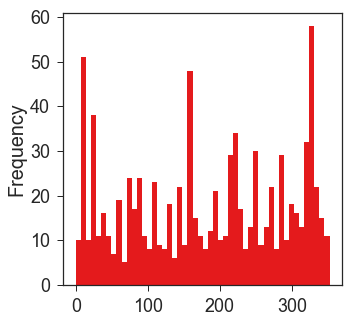

In [28]:
train['Major'].plot(kind = 'hist',bins = 50,figsize = (5,5))
plt.show()

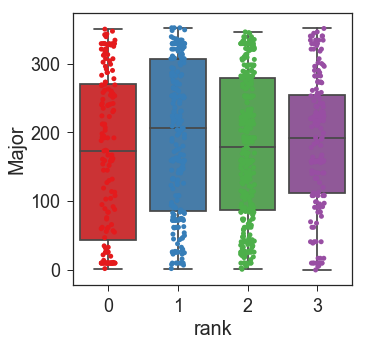

In [29]:
f,axarr = plt.subplots(1,1,figsize=(5,5))
sns.set_context("notebook", font_scale=1.8) 
sns.stripplot(x='rank',y='Major',data=train,jitter=True)
sns.boxplot(x='rank',y='Major',data=train)

In [30]:
#根据Major的分数来对rank做分组，求每个分组的均值
Major_group_mean = pd.DataFrame()
Major_group_mean['Major'] = train.groupby("Major").rank.mean().index
Major_group_mean['mean_rank'] = train.groupby("Major").rank.mean().values 
sns.lmplot(x="Major" , y = "mean_rank" ,data = Major_group_mean)
#没有什么明显的规律，只能通过模型来检验 1）要不要做onehot 2）要不要做特征选择 3)要不要按照频率归类

AttributeError: 'function' object has no attribute 'mean'

6.Target Major

In [ ]:
train['Target Major'].value_counts()

In [ ]:
train[train['Target Major']==398]['rank'].value_counts()/len(train[train['Target Major']==398])

In [ ]:
train['Target Major'].plot(kind = 'hist',bins = 50,figsize = (5,5))
plt.show()

In [ ]:
f,axarr = plt.subplots(1,1,figsize=(5,5))
sns.set_context("notebook", font_scale=1.8) 
sns.stripplot(x='rank',y='Target Major',data=train,jitter=True)
sns.boxplot(x='rank',y='Target Major',data=train)

In [ ]:
#根据Target Major来对rank做分组，求每个分组的均值
Major_group_mean = pd.DataFrame()
Major_group_mean['Target Major'] = train.groupby("Target Major").rank.mean().index
Major_group_mean['mean_rank'] = train.groupby("Target Major").rank.mean().values 
sns.lmplot(x="Target Major" , y = "mean_rank" ,data = Major_group_mean)
#没有什么明显的规律，只能通过模型来检验 1）要不要做onehot 2）要不要做特征选择 3)要不要按照频率归类

#### 3.6类别型特征分析

1.Degree Application

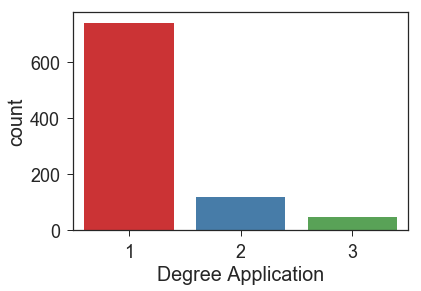

In [31]:
#查看对于类别的不同值个数
sns.countplot(x = "Degree Application", data = train)
#仅申请硕士的人最多

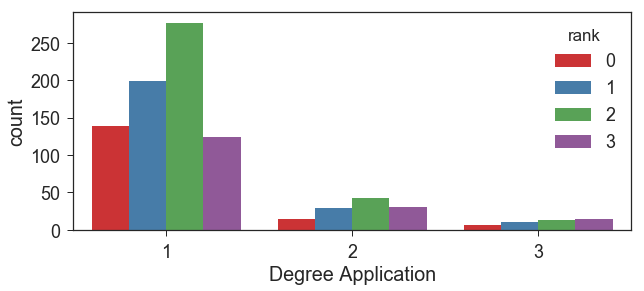

In [32]:
f, axarr = plt.subplots(1, figsize=(10, 4))
sns.countplot(x="Degree Application", hue="rank", data=train)
plt.show()

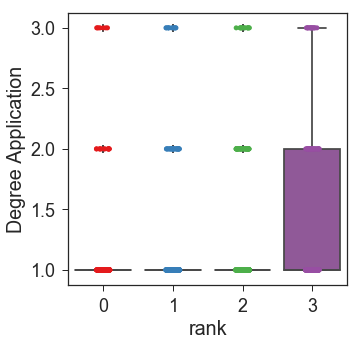

In [33]:
f,axarr = plt.subplots(1,1,figsize=(5,5))
sns.set_context("notebook", font_scale=1.8) # 放大横纵坐标标记，更容易看清
sns.stripplot(x='rank',y='Degree Application',data=train,jitter=True)
sns.boxplot(x='rank',y='Degree Application',data=train)

In [34]:
Dis_app_group_mean = pd.DataFrame()
Dis_app_group_mean['Degree Application'] = train.groupby("Degree Application").rank.mean().index
Dis_app_group_mean['mean_rank'] = train.groupby("Degree Application").rank.mean().values          
sns.lmplot(x="Degree Application" , y = "mean_rank" ,data = Dis_app_group_mean)
#无明显规律，只能通过模型来检验要不要做特征选择去掉

AttributeError: 'function' object has no attribute 'mean'

2.Education

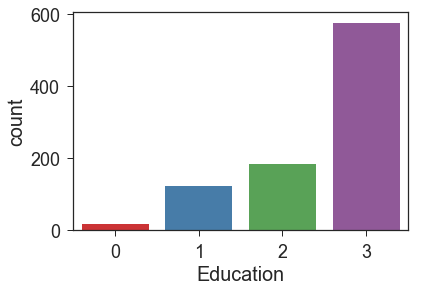

In [35]:
#查看对于类别的不同值个数
sns.countplot(x = "Education", data = train)
#好学校还是很多的

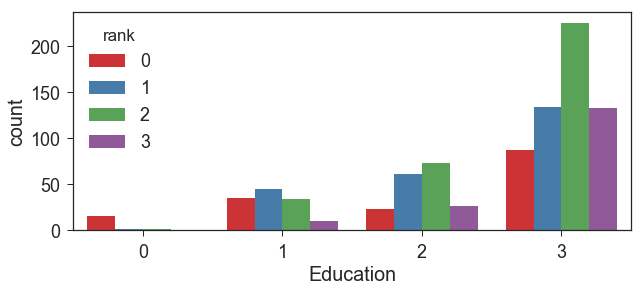

In [36]:
f, axarr = plt.subplots(1, figsize=(10, 4))
sns.countplot(x="Education", hue="rank", data=train)
plt.show()
#可以看出，如果就读学校不好的画申请到的学校rank也不好，就读学校好也不一定能保证申请到好学校

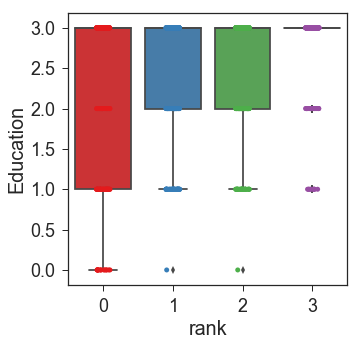

In [37]:
f,axarr = plt.subplots(1,1,figsize=(5,5))
sns.set_context("notebook", font_scale=1.8) # 放大横纵坐标标记，更容易看清
sns.stripplot(x='rank',y='Education',data=train,jitter=True)
sns.boxplot(x='rank',y='Education',data=train)

In [38]:
Edu_group_mean = pd.DataFrame()
Edu_group_mean['Education'] = train.groupby("Education").rank.mean().index
Edu_group_mean['mean_rank'] = train.groupby("Education").rank.mean().values          
sns.lmplot(x="Education" , y = "mean_rank" ,data = Edu_group_mean)
#明显的相关性，看来申请还是很看重目前就读的学校的

AttributeError: 'function' object has no attribute 'mean'

3.IETLS

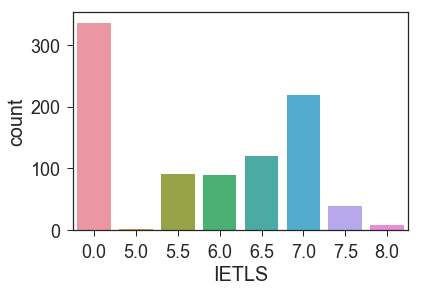

In [39]:
#查看对于类别的不同值个数
sns.countplot(x = "IETLS", data = train)
#需要新建一列判断有无该项分数

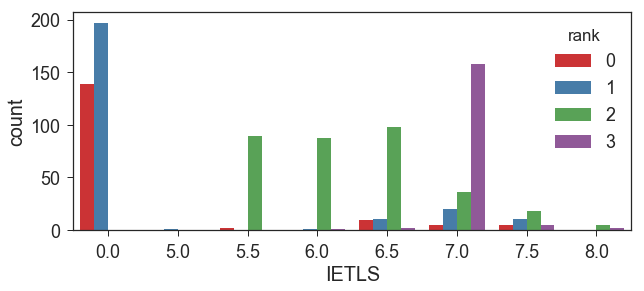

In [40]:
f, axarr = plt.subplots(1, figsize=(10, 4))
sns.countplot(x="IETLS", hue="rank", data=train)
plt.show()
#IETLS为0的话基本申请不到好学校

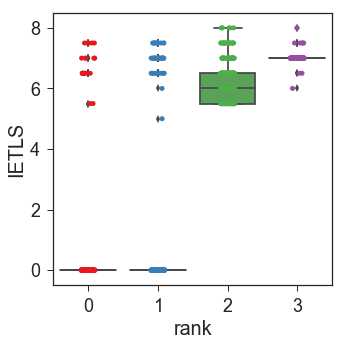

In [41]:
f,axarr = plt.subplots(1,1,figsize=(5,5))
sns.set_context("notebook", font_scale=1.8) # 放大横纵坐标标记，更容易看清
sns.stripplot(x='rank',y='IETLS',data=train,jitter=True)
sns.boxplot(x='rank',y='IETLS',data=train)
#可以看到，rank为3时IETLS成绩都不错

In [42]:
IETLS_group_mean = pd.DataFrame()
IETLS_group_mean['IETLS'] = train.groupby("IETLS").rank.mean().index
IETLS_group_mean['mean_rank'] = train.groupby("IETLS").rank.mean().values          
sns.lmplot(x="IETLS" , y = "mean_rank" ,data = IETLS_group_mean)
#明显的相关性

AttributeError: 'function' object has no attribute 'mean'

4.Distinguished Internship

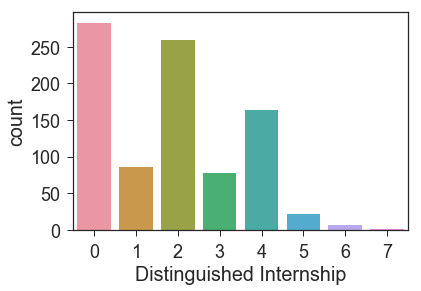

In [43]:
#查看对于类别的不同值个数
sns.countplot(x = "Distinguished Internship", data = train)

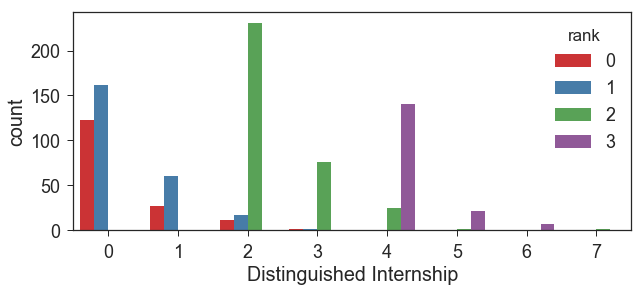

In [44]:
#世界500强实习经历越丰富，rank越高
f, axarr = plt.subplots(1, figsize=(10, 4))
sns.countplot(x="Distinguished Internship", hue="rank", data=train)
plt.show()

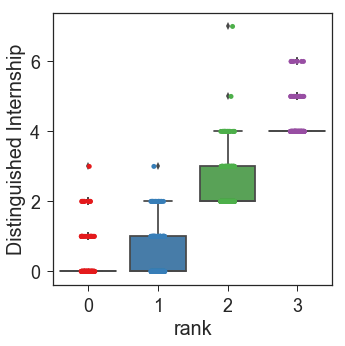

In [45]:
f,axarr = plt.subplots(1,1,figsize=(5,5))
sns.set_context("notebook", font_scale=1.8) # 放大横纵坐标标记，更容易看清
sns.stripplot(x='rank',y='Distinguished Internship',data=train,jitter=True)
sns.boxplot(x='rank',y='Distinguished Internship',data=train)

In [46]:
Dis_Intern_group_mean = pd.DataFrame()
Dis_Intern_group_mean['Distinguished Internship'] = train.groupby("Distinguished Internship").rank.mean().index
Dis_Intern_group_mean['mean_rank'] = train.groupby("Distinguished Internship").rank.mean().values          
#明显的正相关性质
sns.lmplot(x="Distinguished Internship" , y = "mean_rank" ,data = Dis_Intern_group_mean)

AttributeError: 'function' object has no attribute 'mean'

5.General Internship

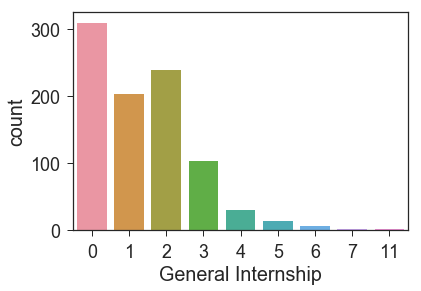

In [47]:
#查看对于类别的不同值个数
sns.countplot(x = "General Internship", data = train)

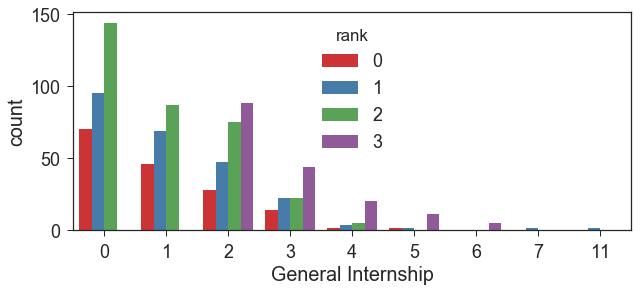

In [48]:
f, axarr = plt.subplots(1, figsize=(10, 4))
sns.countplot(x="General Internship", hue="rank", data=train)
plt.show()
#General Internship多的话还是很有优势

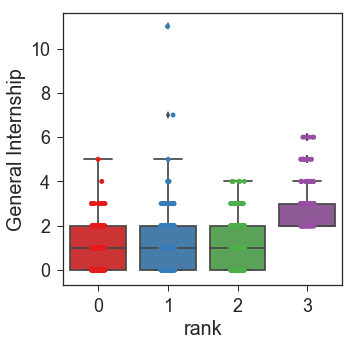

In [49]:
f,axarr = plt.subplots(1,1,figsize=(5,5))
sns.set_context("notebook", font_scale=1.8) # 放大横纵坐标标记，更容易看清
sns.stripplot(x='rank',y='General Internship',data=train,jitter=True)
sns.boxplot(x='rank',y='General Internship',data=train)
#rank为3时，General Internship都不少

In [50]:
Gen_Intern_group_mean = pd.DataFrame()
Gen_Intern_group_mean['General Internship'] = train.groupby("General Internship").rank.mean().index
Gen_Intern_group_mean['mean_rank'] = train.groupby("General Internship").rank.mean().values          
#明显的正相关性质
sns.lmplot(x="General Internship" , y = "mean_rank" ,data = Gen_Intern_group_mean)
#可以看到之前是正相关的，所以General Internship太多了也不是好事
#可以加一列新特征判断是否大于6

AttributeError: 'function' object has no attribute 'mean'

6.Research Experience

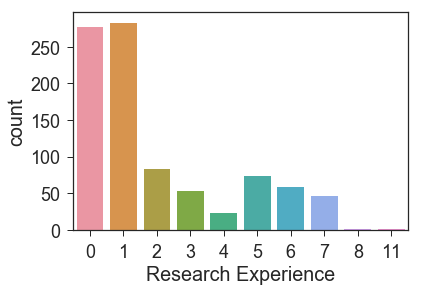

In [51]:
#查看对于类别的不同值个数
sns.countplot(x = "Research Experience", data = train)

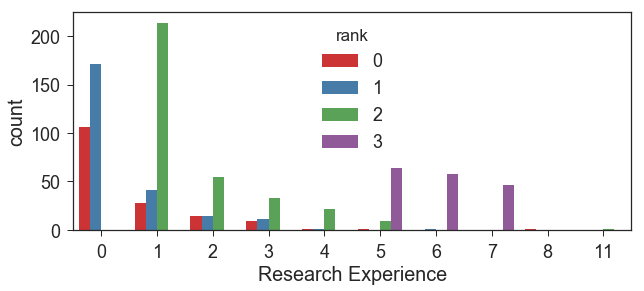

In [52]:
f, axarr = plt.subplots(1, figsize=(10, 4))
sns.countplot(x="Research Experience", hue="rank", data=train)
plt.show()
#Research Experience多的话还是很有优势

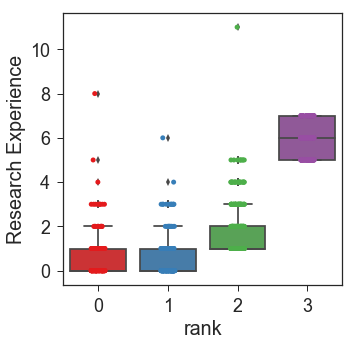

In [53]:
f,axarr = plt.subplots(1,1,figsize=(5,5))
sns.set_context("notebook", font_scale=1.8) # 放大横纵坐标标记，更容易看清
sns.stripplot(x='rank',y='Research Experience',data=train,jitter=True)
sns.boxplot(x='rank',y='Research Experience',data=train)
#明显的正相关

In [54]:
Res_exp_group_mean = pd.DataFrame()
Res_exp_group_mean['Research Experience'] = train.groupby("Research Experience").rank.mean().index
Res_exp_group_mean['mean_rank'] = train.groupby("Research Experience").rank.mean().values          
#明显的正相关性质
sns.lmplot(x="Research Experience" , y = "mean_rank" ,data = Res_exp_group_mean)
#可以看到之前是正相关的，所以Research Experience太多了也不是好事
#可以加一列新特征判断是否大于7

AttributeError: 'function' object has no attribute 'mean'

7.Other Experience

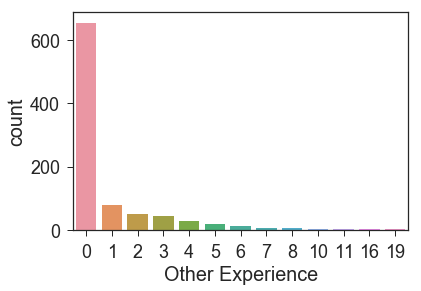

In [55]:
#查看对于类别的不同值个数
sns.countplot(x = "Other Experience", data = train)
#加一列新特征判断是否为0，通过建模交叉验证error来判断要不要加入

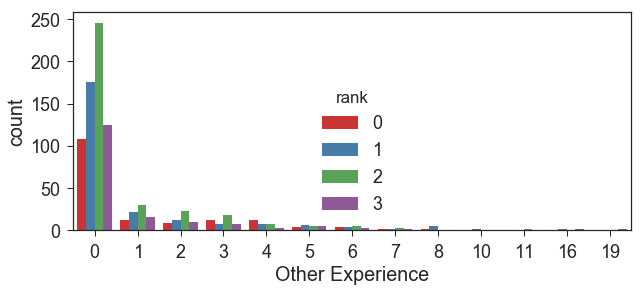

In [56]:
f, axarr = plt.subplots(1, figsize=(10, 4))
sns.countplot(x="Other Experience", hue="rank", data=train)
plt.show()#这个图看不出来啥

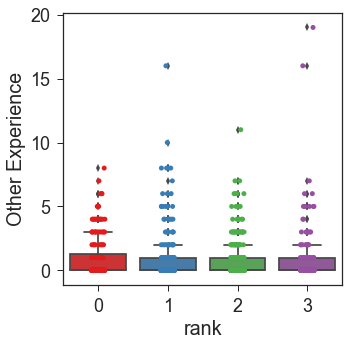

In [57]:
f,axarr = plt.subplots(1,1,figsize=(5,5))
sns.set_context("notebook", font_scale=1.8) # 放大横纵坐标标记，更容易看清
sns.stripplot(x='rank',y='Other Experience',data=train,jitter=True)
sns.boxplot(x='rank',y='Other Experience',data=train)

In [58]:
Oth_exp_group_mean = pd.DataFrame()
Oth_exp_group_mean['Other Experience'] = train.groupby("Other Experience").rank.mean().index
Oth_exp_group_mean['mean_rank'] = train.groupby("Other Experience").rank.mean().values          
#明显的正相关性质
sns.lmplot(x="Other Experience" , y = "mean_rank" ,data = Oth_exp_group_mean)
#相关性还是有的，所以不能删除

AttributeError: 'function' object has no attribute 'mean'

8.year（可能有大小年变化）

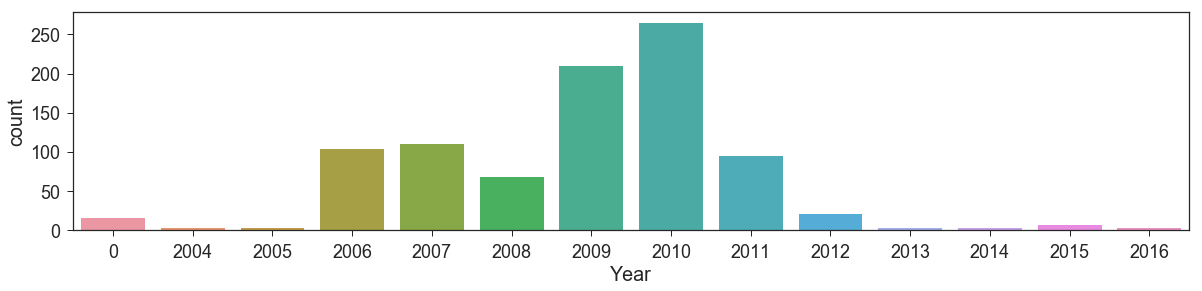

In [59]:
#查看对于类别的不同值个数
f, axarr = plt.subplots(1, figsize=(20, 4))
sns.countplot(x = "Year", data = train)

In [60]:
train['Year'].value_counts()
#Year为0的是异常值,但是onehot后没影响

2010    265
2009    210
2007    110
2006    103
2011     94
2008     67
2012     20
0        15
2015      6
2016      2
2014      2
2013      2
2005      2
2004      2
Name: Year, dtype: int64

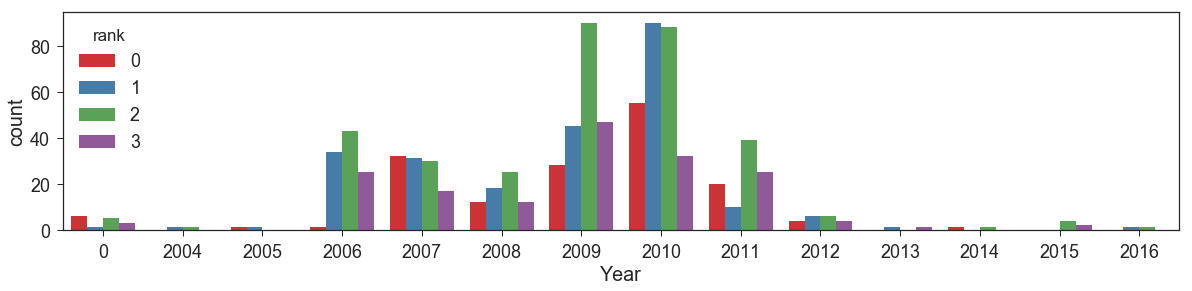

In [61]:
f, axarr = plt.subplots(1, figsize=(20, 4))
sns.countplot(x="Year", hue="rank", data=train)
plt.show()
#Research Experience多的话还是很有优势

In [62]:
year_group_mean = pd.DataFrame()
year_group_mean['Year'] = train.groupby("Year").rank.mean().index
year_group_mean['mean_rank'] = train.groupby("Year").rank.mean().values          
print(year_group_mean)

AttributeError: 'function' object has no attribute 'mean'

3.3对类别型特征做onehot

#### 3.7分析总体特征相关性

热力图

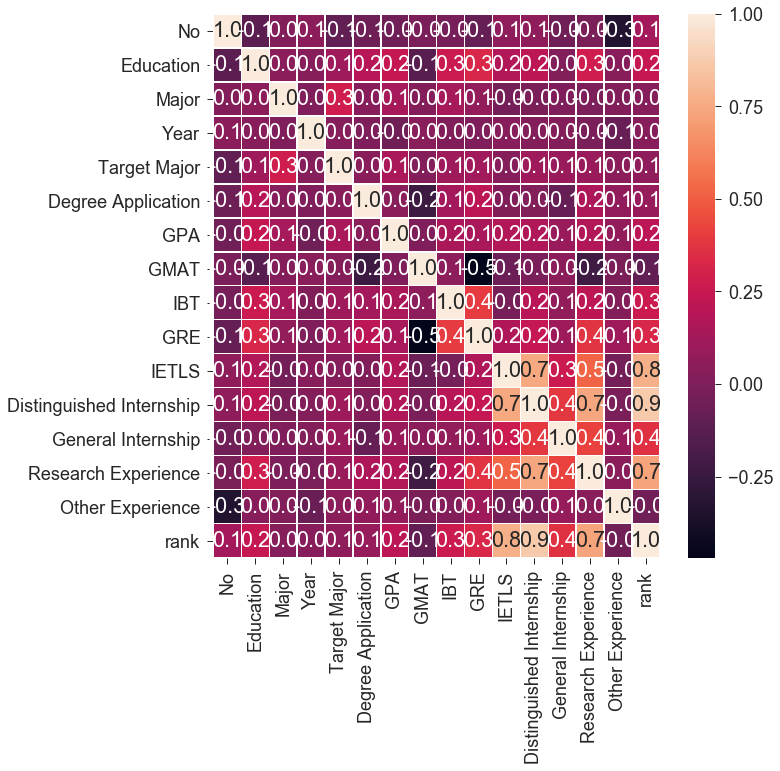

In [63]:
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

对于相关程度不大的特征，我们可以考虑特征组合或者用其他方法（比如GBDT）给出新的feature importance，看是否真的无用

### 4、特征工程

#### 4.1处理类别型特征

#### 策略1：不做任何特征工程

In [64]:
train = pd.read_csv('EdTech_train_data.csv')
X = train.drop(['No','rank'],axis=1).values
y = train['rank'].values
model = RandomForestClassifier(n_estimators=100,random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.9120879120879121
accuracy: 0.8791208791208791
accuracy: 0.8681318681318682
accuracy: 0.8888888888888888
accuracy: 0.9111111111111111
accuracy: 0.9111111111111111
accuracy: 0.8555555555555555
accuracy: 0.8666666666666667
accuracy: 0.9101123595505618
accuracy: 0.9090909090909091
mean_acc 0.8911877261315462


In [65]:
model = XGBClassifier(n_estimators=50, n_jobs=-1,random_state=0)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.9230769230769231
accuracy: 0.8901098901098901
accuracy: 0.8351648351648352
accuracy: 0.8777777777777778
accuracy: 0.9111111111111111
accuracy: 0.9222222222222223
accuracy: 0.8333333333333334
accuracy: 0.8444444444444444
accuracy: 0.8314606741573034
accuracy: 0.8977272727272727
mean_acc 0.8766428484125113


#### 策略2：删除Degree Application

In [66]:
train = pd.read_csv('EdTech_train_data.csv')
X = train.drop(['No','rank','Degree Application'],axis=1).values
y = train['rank'].values
model = RandomForestClassifier(n_estimators=100,random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))
#看来不能删除

accuracy: 0.8901098901098901
accuracy: 0.8791208791208791
accuracy: 0.8461538461538461
accuracy: 0.8555555555555555
accuracy: 0.9111111111111111
accuracy: 0.9
accuracy: 0.8666666666666667
accuracy: 0.8333333333333334
accuracy: 0.898876404494382
accuracy: 0.9090909090909091
mean_acc 0.8790018595636573


#### 策略3：对Degree Application做onehot

In [67]:
train = pd.read_csv('EdTech_train_data.csv')
Degree = pd.DataFrame(train['Degree Application'],dtype='object')
Degree_hot = pd.get_dummies(Degree)
train_X = train.drop(['No','rank','Degree Application'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.join(Degree_hot,how='outer').values
y = train_y.values
model = RandomForestClassifier(n_estimators=100,random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.9010989010989011
accuracy: 0.9010989010989011
accuracy: 0.8131868131868132
accuracy: 0.8555555555555555
accuracy: 0.9
accuracy: 0.9111111111111111
accuracy: 0.8555555555555555
accuracy: 0.8444444444444444
accuracy: 0.8764044943820225
accuracy: 0.9204545454545454
mean_acc 0.877891032188785


#### 策略4：对Education做onehot

In [68]:
train = pd.read_csv('EdTech_train_data.csv')
Edu = pd.DataFrame(train['Education'],dtype='object')
Edu_hot = pd.get_dummies(Edu)
train_X = train.drop(['No','rank','Education'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.join(Edu_hot,how='outer').values
y = train_y.values
X = train_X.join(Degree_hot,how='outer').values
y = train_y.values
model = RandomForestClassifier(n_estimators=100,random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.9120879120879121
accuracy: 0.9010989010989011
accuracy: 0.8461538461538461
accuracy: 0.8777777777777778
accuracy: 0.9222222222222223
accuracy: 0.9
accuracy: 0.8555555555555555
accuracy: 0.8666666666666667
accuracy: 0.8876404494382022
accuracy: 0.8977272727272727
mean_acc 0.8866930603728356


#### 策略5：对IETLS做onehot

In [69]:
train = pd.read_csv('EdTech_train_data.csv')
IET = pd.DataFrame(train['IETLS'],dtype='object')
IET_hot = pd.get_dummies(IET)
train_X = train.drop(['No','rank','IETLS'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.join(IET_hot,how='outer').values
y = train_y.values
model = RandomForestClassifier(n_estimators=100,random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.9010989010989011
accuracy: 0.9010989010989011
accuracy: 0.8681318681318682
accuracy: 0.8444444444444444
accuracy: 0.9333333333333333
accuracy: 0.9
accuracy: 0.8666666666666667
accuracy: 0.8222222222222222
accuracy: 0.9101123595505618
accuracy: 0.8863636363636364
mean_acc 0.8833472332910535


#### 策略6：对IETLS新增一列判断是否大于0

In [70]:
train = pd.read_csv('EdTech_train_data.csv')
IETLS = pd.DataFrame(train['IETLS'])
IETLS[IETLS<1]=0
IETLS[IETLS>=1]=1
train_X = copy.deepcopy(train)
train_X['IETLS>=1'] = IETLS.values
train_X = train_X.drop(['No','rank'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.values
y = train_y.values
model = RandomForestClassifier(n_estimators=100,random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.9120879120879121
accuracy: 0.8791208791208791
accuracy: 0.8791208791208791
accuracy: 0.8444444444444444
accuracy: 0.9
accuracy: 0.9
accuracy: 0.8555555555555555
accuracy: 0.8333333333333334
accuracy: 0.898876404494382
accuracy: 0.8977272727272727
mean_acc 0.880026668088466


#### 对雅思为0的填充均值或者中位数

In [71]:
train = pd.read_csv('EdTech_train_data.csv')
IET = train['IETLS'].values
IET_mean = np.mean(IET)
IET_mead = np.median(IET)
for i in range(len(IET)):
    if IET[i]==0:
        IET[i]=IET_mead
train_X = train.drop(['No','rank'],axis=1)
# train_X['IET'] = IET
train_y = train['rank']
#将dataframe按列合并
X = train_X.values
y = train_y.values
model = RandomForestClassifier(n_estimators=100,random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))
#没什么用

accuracy: 0.8901098901098901
accuracy: 0.8791208791208791
accuracy: 0.8571428571428571
accuracy: 0.8555555555555555
accuracy: 0.9222222222222223
accuracy: 0.9
accuracy: 0.8555555555555555
accuracy: 0.8555555555555555
accuracy: 0.8876404494382022
accuracy: 0.9204545454545454
mean_acc 0.8823357510155263


#### 策略7：对Distinguished Internship做one_hot

In [72]:
train = pd.read_csv('EdTech_train_data.csv')
Dis_Intern = pd.DataFrame(train['Distinguished Internship'],dtype='object')
Dis_Intern_hot = pd.get_dummies(Dis_Intern)
train_X = train.drop(['No','rank','Distinguished Internship'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.join(Dis_Intern_hot,how='outer').values
y = train_y.values
model = RandomForestClassifier(n_estimators=100,random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.9010989010989011
accuracy: 0.8791208791208791
accuracy: 0.8901098901098901
accuracy: 0.8333333333333334
accuracy: 0.9111111111111111
accuracy: 0.8888888888888888
accuracy: 0.8777777777777778
accuracy: 0.8555555555555555
accuracy: 0.898876404494382
accuracy: 0.8977272727272727
mean_acc 0.8833600014217993


#### 策略8：对General Internship做one_hot

In [73]:
train = pd.read_csv('EdTech_train_data.csv')
Gen_Intern = pd.DataFrame(train['General Internship'],dtype='object')
Gen_Intern_hot = pd.get_dummies(Gen_Intern)
train_X = train.drop(['No','rank','General Internship'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.join(Gen_Intern_hot,how='outer').values
y = train_y.values
model = RandomForestClassifier(n_estimators=100,random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.8901098901098901
accuracy: 0.8791208791208791
accuracy: 0.8901098901098901
accuracy: 0.8888888888888888
accuracy: 0.9222222222222223
accuracy: 0.9
accuracy: 0.8666666666666667
accuracy: 0.8333333333333334
accuracy: 0.8764044943820225
accuracy: 0.9090909090909091
mean_acc 0.8855947173924701


#### 策略9：对General Internship新增一列判断是否大于7

In [74]:
train = pd.read_csv('EdTech_train_data.csv')
Gen_Intern = pd.DataFrame(train['General Internship'])
Gen_Intern[Gen_Intern<7]=0
Gen_Intern[Gen_Intern>=7]=1

train_X = copy.deepcopy(train)
train_X['Gen_Intern>=7'] = Gen_Intern.values
train_X = train_X.drop(['No','rank'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.values
y = train_y.values
model = RandomForestClassifier(n_estimators=100,random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.9010989010989011
accuracy: 0.9010989010989011
accuracy: 0.8901098901098901
accuracy: 0.8444444444444444
accuracy: 0.9111111111111111
accuracy: 0.9
accuracy: 0.8444444444444444
accuracy: 0.8333333333333334
accuracy: 0.8876404494382022
accuracy: 0.8977272727272727
mean_acc 0.88110087478065


#### 策略10：对Research Experience做one_hot

In [75]:
train = pd.read_csv('EdTech_train_data.csv')
Re_exp = pd.DataFrame(train['Research Experience'],dtype='object')
Re_exp_hot = pd.get_dummies(Re_exp)
train_X = train.drop(['No','rank','Research Experience'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.join(Re_exp_hot,how='outer').values
y = train_y.values
model = RandomForestClassifier(n_estimators=100,random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.8901098901098901
accuracy: 0.8901098901098901
accuracy: 0.8351648351648352
accuracy: 0.8555555555555555
accuracy: 0.9111111111111111
accuracy: 0.9111111111111111
accuracy: 0.8555555555555555
accuracy: 0.8555555555555555
accuracy: 0.8539325842696629
accuracy: 0.9090909090909091
mean_acc 0.8767296997634076


#### 策略11：对Research Experience新增一列判断是否大于7

In [76]:
train = pd.read_csv('EdTech_train_data.csv')
Re_exp = pd.DataFrame(train['Research Experience'])
Re_exp[Re_exp<7]=0
Re_exp[Re_exp>=7]=1
train_X = copy.deepcopy(train)
train_X['Re_exp>=7'] = Re_exp.values
train_X = train_X.drop(['No','rank'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.values
y = train_y.values
model = RandomForestClassifier(n_estimators=100,random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.9010989010989011
accuracy: 0.8791208791208791
accuracy: 0.8901098901098901
accuracy: 0.8555555555555555
accuracy: 0.9
accuracy: 0.9111111111111111
accuracy: 0.8444444444444444
accuracy: 0.8444444444444444
accuracy: 0.8876404494382022
accuracy: 0.8977272727272727
mean_acc 0.8811252948050701


#### 策略12：对Other Experience做one_hot

In [77]:
train = pd.read_csv('EdTech_train_data.csv')
Oth_exp = pd.DataFrame(train['Other Experience'],dtype='object')
Oth_exp_hot = pd.get_dummies(Oth_exp)
train_X = train.drop(['No','rank','Other Experience'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.join(Oth_exp_hot,how='outer').values
y = train_y.values

model = RandomForestClassifier(n_estimators=100,random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))
#没有提高，而且个数有序的，故不作onehot

accuracy: 0.9010989010989011
accuracy: 0.8791208791208791
accuracy: 0.8791208791208791
accuracy: 0.8555555555555555
accuracy: 0.9
accuracy: 0.9222222222222223
accuracy: 0.8777777777777778
accuracy: 0.8444444444444444
accuracy: 0.898876404494382
accuracy: 0.9090909090909091
mean_acc 0.886730797292595


#### 策略13：对Other Experience新增一列判断是否大于0

In [78]:
train = pd.read_csv('EdTech_train_data.csv')
Oth_exp = pd.DataFrame(train['Other Experience'])
Oth_exp[Oth_exp<1]=0
Oth_exp[Oth_exp>=1]=1


train_X = copy.deepcopy(train)
train_X['Oth_exp>=1'] = Oth_exp.values
train_X = train_X.drop(['No','rank'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.values
y = train_y.values

model = RandomForestClassifier(n_estimators=100,random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.8901098901098901
accuracy: 0.9010989010989011
accuracy: 0.8681318681318682
accuracy: 0.8222222222222222
accuracy: 0.9111111111111111
accuracy: 0.9
accuracy: 0.8333333333333334
accuracy: 0.8222222222222222
accuracy: 0.8764044943820225
accuracy: 0.9090909090909091
mean_acc 0.873372495170248


#### 策略14：对Year做one_hot

In [79]:
train = pd.read_csv('EdTech_train_data.csv')
Year = pd.DataFrame(train['Year'],dtype='object')
Year_hot = pd.get_dummies(Year)
train_X = train.drop(['No','rank','Year'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.join(Year_hot,how='outer').values
y = train_y.values

model = RandomForestClassifier(n_estimators=100,random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.9120879120879121
accuracy: 0.8681318681318682
accuracy: 0.8351648351648352
accuracy: 0.8666666666666667
accuracy: 0.8777777777777778
accuracy: 0.8888888888888888
accuracy: 0.8444444444444444
accuracy: 0.8333333333333334
accuracy: 0.8876404494382022
accuracy: 0.9204545454545454
mean_acc 0.8734590721388475


类别型特征最终处理结果：  
1、试过了所有方法都无效

#### 4.2处理数值型特征

#### 策略1：对IBT新增一列判断是否大于0

In [80]:
train = pd.read_csv('EdTech_train_data.csv')
IBT = pd.DataFrame(train['IBT'])
IBT[IBT<1]=0
IBT[IBT>=1]=1
train_X = copy.deepcopy(train)
train_X['IBT>=1'] = IBT.values
train_X = train_X.drop(['No','rank'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.values
y = train_y.values

model = RandomForestClassifier(n_estimators=100,random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.8681318681318682
accuracy: 0.8791208791208791
accuracy: 0.8681318681318682
accuracy: 0.8333333333333334
accuracy: 0.9333333333333333
accuracy: 0.9
accuracy: 0.8444444444444444
accuracy: 0.8444444444444444
accuracy: 0.898876404494382
accuracy: 0.9090909090909091
mean_acc 0.8778907484525462


#### 策略2：对GMAT新增一列判断是否大于0

In [81]:
train = pd.read_csv('EdTech_train_data.csv')
GMAT = pd.DataFrame(train['GMAT'])
GMAT[GMAT<1]=0
GMAT[GMAT>=1]=1
train_X = copy.deepcopy(train)
train_X['GMAT>=1'] = GMAT.values
train_X = train_X.drop(['No','rank'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.values
y = train_y.values

model = RandomForestClassifier(n_estimators=100,random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.9010989010989011
accuracy: 0.8791208791208791
accuracy: 0.8791208791208791
accuracy: 0.8555555555555555
accuracy: 0.8777777777777778
accuracy: 0.9111111111111111
accuracy: 0.8555555555555555
accuracy: 0.8444444444444444
accuracy: 0.898876404494382
accuracy: 0.9090909090909091
mean_acc 0.8811752417370394


#### 策略3：对GPA新增一列判断是否大于0

In [82]:
train = pd.read_csv('EdTech_train_data.csv')
GPA = pd.DataFrame(train[' GPA'])
GPA[GPA<1]=0
GPA[GPA>=1]=1
train_X = copy.deepcopy(train)
train_X[' GPA>=1'] = GPA.values
train_X = train_X.drop(['No','rank'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.values
y = train_y.values

model = RandomForestClassifier(n_estimators=100,random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.8901098901098901
accuracy: 0.8901098901098901
accuracy: 0.8901098901098901
accuracy: 0.8888888888888888
accuracy: 0.9333333333333333
accuracy: 0.9111111111111111
accuracy: 0.8555555555555555
accuracy: 0.8222222222222222
accuracy: 0.898876404494382
accuracy: 0.9090909090909091
mean_acc 0.8889408095026072


#### 策略4：对GRE新增一列判断是否大于0

In [83]:
train = pd.read_csv('EdTech_train_data.csv')
GRE = pd.DataFrame(train['GRE'])
GRE[GRE<1]=0
GRE[GRE>=1]=1
train_X = copy.deepcopy(train)
train_X['GRE>=1'] = GRE.values
train_X = train_X.drop(['No','rank'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.values
y = train_y.values

model = RandomForestClassifier(n_estimators=100,random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.9120879120879121
accuracy: 0.8791208791208791
accuracy: 0.9010989010989011
accuracy: 0.8333333333333334
accuracy: 0.9111111111111111
accuracy: 0.9222222222222223
accuracy: 0.8333333333333334
accuracy: 0.8444444444444444
accuracy: 0.898876404494382
accuracy: 0.9090909090909091
mean_acc 0.8844719450337427


#### 策略5：对Major做onehot

In [84]:
train = pd.read_csv('EdTech_train_data.csv')
Major = pd.DataFrame(train['Major'],dtype='object')
Major_hot = pd.get_dummies(Major)
train_X =  train.drop(['No','rank','Major'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.join(Major_hot,how='outer').values
y = train_y.values

model = RandomForestClassifier(n_estimators=100,random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.8791208791208791
accuracy: 0.8791208791208791
accuracy: 0.8901098901098901
accuracy: 0.8555555555555555
accuracy: 0.9333333333333333
accuracy: 0.9111111111111111
accuracy: 0.8555555555555555
accuracy: 0.8333333333333334
accuracy: 0.898876404494382
accuracy: 0.9090909090909091
mean_acc 0.8845207850825828


#### 策略6：删除Major

In [85]:
train = pd.read_csv('EdTech_train_data.csv')
train_X = train.drop(['No','rank','Major'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.values
y = train_y.values

model = RandomForestClassifier(n_estimators=10,random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.8351648351648352
accuracy: 0.9230769230769231
accuracy: 0.8571428571428571
accuracy: 0.8444444444444444
accuracy: 0.9222222222222223
accuracy: 0.9
accuracy: 0.8555555555555555
accuracy: 0.8222222222222222
accuracy: 0.8876404494382022
accuracy: 0.8977272727272727
mean_acc 0.8745196781994535


#### 策略7：将Major做word2vector转化（训练神经网络的数据太少，放弃该想法）

但可以画出网络结构图以及想法，答辩PPT使用

#### 策略8：计算出每个不同取值对应的label的取值变化，对major再分类

In [86]:
train = pd.read_csv('EdTech_train_data.csv')
#根据Major的分数来对rank做分组，求每个分组的均值
Major_group_mean = pd.DataFrame()
Major_group_mean['Major'] = train.groupby("Major")['rank'].mean().index
Major_group_mean['mean_rank'] = train.groupby("Major")['rank'].mean().values 
df = Major_group_mean.sort_index(by='mean_rank')
m1 = df[0:80]['Major'].values
m2 = df[80:160]['Major'].values
m3 = df[160:240]['Major'].values
m4 = df[240:]['Major'].values
#构建替换字典
dic = {}
for i in m1:
    dic[i]='A'
for i in m2:
    dic[i]='B'
for i in m3:
    dic[i]='C'
for i in m4:
    dic[i]='D'
Major = pd.DataFrame(train['Major'],dtype='object')
Major.replace(dic,inplace=True)

1)做onehot

In [87]:
Major_hot = pd.get_dummies(Major)
train_X = train.drop(['No','rank','Major'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.join(Major_hot,how='outer').values
y = train_y.values

model = RandomForestClassifier(n_estimators=100,random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.9230769230769231
accuracy: 0.9120879120879121
accuracy: 0.8571428571428571
accuracy: 0.8222222222222222
accuracy: 0.9222222222222223
accuracy: 0.9111111111111111
accuracy: 0.8555555555555555
accuracy: 0.8777777777777778
accuracy: 0.898876404494382
accuracy: 0.8977272727272727
mean_acc 0.8877800258418237


2）labelencoder

In [88]:
df = Major_group_mean.sort_index(by='mean_rank')
m1 = df[0:80]['Major'].values
m2 = df[80:160]['Major'].values
m3 = df[160:240]['Major'].values
m4 = df[240:]['Major'].values
#构建替换字典
dic = {}
for i in m1:
    dic[i]=1
for i in m2:
    dic[i]=2
for i in m3:
    dic[i]=3
for i in m4:
    dic[i]=4
Major = pd.DataFrame(train['Major'],dtype='object')
Major.replace(dic,inplace=True)

In [89]:
train_X = train.drop(['No','rank','Major'],axis=1)
train_X['Major'] = Major
train_y = train['rank']
#将dataframe按列合并
X = train_X.values
y = train_y.values

model = RandomForestClassifier(n_estimators=100,random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))
#都没什么用

accuracy: 0.8901098901098901
accuracy: 0.9010989010989011
accuracy: 0.8681318681318682
accuracy: 0.8444444444444444
accuracy: 0.9222222222222223
accuracy: 0.9
accuracy: 0.8333333333333334
accuracy: 0.8666666666666667
accuracy: 0.9213483146067416
accuracy: 0.8636363636363636
mean_acc 0.8810992004250432


#### 策略9：删除Target Major

In [90]:
train = pd.read_csv('EdTech_train_data.csv')
train_X = train.drop(['No','rank','Target Major'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.values
y = train_y.values

model = RandomForestClassifier(n_estimators=100,random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.9120879120879121
accuracy: 0.8901098901098901
accuracy: 0.8901098901098901
accuracy: 0.8222222222222222
accuracy: 0.9111111111111111
accuracy: 0.9111111111111111
accuracy: 0.8666666666666667
accuracy: 0.8444444444444444
accuracy: 0.8876404494382022
accuracy: 0.8977272727272727
mean_acc 0.8833230970028723


#### 策略10：对Target Major做onehot

In [91]:
train = pd.read_csv('EdTech_train_data.csv')
Tar_Major = pd.DataFrame(train['Target Major'],dtype='object')
Tar_Major_hot = pd.get_dummies(Tar_Major)
train_X = train.drop(['No','rank','Target Major'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.join(Tar_Major_hot,how='outer').values
y = train_y.values

model = RandomForestClassifier(n_estimators=100,random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.8681318681318682
accuracy: 0.8681318681318682
accuracy: 0.9120879120879121
accuracy: 0.8444444444444444
accuracy: 0.8888888888888888
accuracy: 0.9
accuracy: 0.8444444444444444
accuracy: 0.8444444444444444
accuracy: 0.8651685393258427
accuracy: 0.8977272727272727
mean_acc 0.8733469682626985


#### 策略11：计算出每个不同取值对应的label的取值变化，对Target Major再分类

In [92]:
#根据Target Major的分数来对rank做分组，求每个分组的均值
train = pd.read_csv('EdTech_train_data.csv')
Major_group_mean = pd.DataFrame()
Major_group_mean['Target Major'] = train.groupby("Target Major")['rank'].mean().index
Major_group_mean['mean_rank'] = train.groupby("Target Major")['rank'].mean().values 
df = Major_group_mean.sort_index(by='mean_rank')
m1 = df[0:100]['Target Major'].values
m2 = df[100:200]['Target Major'].values
m3 = df[200:300]['Target Major'].values
m4 = df[300:]['Target Major'].values
#构建替换字典
dic = {}
for i in m1:
    dic[i]='A'
for i in m2:
    dic[i]='B'
for i in m3:
    dic[i]='C'
for i in m4:
    dic[i]='D'
Tar_Major = pd.DataFrame(train['Target Major'],dtype='object')
Tar_Major.replace(dic,inplace=True)
Tar_Major_hot = pd.get_dummies(Tar_Major)

train_X = train.drop(['No','rank','Target Major'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.join(Tar_Major_hot,how='outer').values
y = train_y.values

model = RandomForestClassifier(n_estimators=100,random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.9230769230769231
accuracy: 0.8901098901098901
accuracy: 0.8131868131868132
accuracy: 0.8555555555555555
accuracy: 0.8888888888888888
accuracy: 0.9222222222222223
accuracy: 0.8444444444444444
accuracy: 0.8555555555555555
accuracy: 0.8876404494382022
accuracy: 0.9204545454545454
mean_acc 0.8801135287933042


数值型特征最终处理结果：  
1、对IBT新增一列判断是否大于0

#### 4.3将PCA降维之后的信息做拼接进行训练

#### 4.4 数据中既有稀疏特征，又有稠密特征，可以考虑使用线性模型对稀疏特征进行建模，将其输出与稠密特征一起再输入 XGBoost/DNN 建模

#### 4.5提取属性特征，距离特征和基于分组的统计特征等构建新特征

#### 4.6Feature Engineering + GBDT 特征编码 + FFM + Blending